In [24]:
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, svd, eigh, det

from jax.lax import scan
import jax
from scipy.linalg import solve_discrete_are
from tqdm import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial

from jax_vi import KL_gaussian, log_likelihood, KL_sum
from jax_filters import apply_filtering_fixed_nonlinear, kalman_filter_process, filter_step
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix




key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
p = 2  # Observation dimension
J0 = 0 # burn in period
N = 10 # Monte Carlo samples
F = 8.0
dt = 0.05
num_steps = 1000  # Number of time steps

# Model parameters
m0 = jnp.ones((n,))
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
q = random.normal(key, (n, n))/5
Q = q@q.T + jnp.eye(n)*0.1#jnp.eye(n) * 5.0    # Process noise covariance matrix (Sigma in Julia code)

Q = jnp.eye(n) * 0.1    # Process noise covariance matrix (Sigma in Julia code)
R = jnp.eye(n) * 0.5    # Observation noise covariance matrix (Gamma)
inv_R = inv(R)
H = jnp.eye(n)          # Observation matrix
observation_interval = 1

# State initialization
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state

l96_model = Lorenz96(dt = dt, F = F)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)
# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)


In [25]:
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)
y = observations

In [26]:
from functools import partial


@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, H, Q, R, y, key, num_steps, J0):
    states, covariances = apply_filtering_fixed_nonlinear(m0, C0, y, K, n, l96_step, jac_func, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(states, covariances, n, l96_step, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, states, covariances), y, H, R, num_steps, J0) 
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    print(cost)
    return cost


from functools import partial


@partial(jit, static_argnums=(3))
def var_cost_single_step(K, m0, C0, n, Q, H, R, y_curr, key, J, J0):
    (m_update, C_update), _  =  filter_step((m0,C0), y_curr, K, n, l96_step, jac_func, H, Q, R)
    
    log_likelihood_val = log_likelihood(m_update[jnp.newaxis, :], y_curr[jnp.newaxis, :], H, R, J=1, J0=J0)
    # Calculate the KL divergence between the predicted and updated state distributions
    m_pred = state_transition_function(m0)
    M = jac_func(m0)
    C_pred = M @ C0 @ M.T + Q
    kl_divergence = KL_gaussian(n, m_update, C_update, m_pred, C_pred)
    
    # Combine the KL divergence and the negative log-likelihood to form the cost
    cost = kl_divergence - log_likelihood_val
    return cost


In [27]:
m, C, K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)
print(K[-1])
K_steady = jnp.mean(K[-10:, :, :], axis=0)

[[ 0.3817721  -0.0685936   0.01797695 ...  0.01470149  0.04676234
  -0.01691018]
 [-0.06859362  0.331138   -0.01825415 ...  0.0036553  -0.00376566
   0.0095753 ]
 [ 0.01797694 -0.01825416  0.3665862  ...  0.00234407  0.00416428
   0.00703784]
 ...
 [ 0.01470149  0.00365529  0.00234407 ...  0.35023788  0.03981472
   0.01987791]
 [ 0.04676236 -0.00376565  0.00416428 ...  0.03981471  0.3723227
   0.04906635]
 [-0.01691019  0.00957529  0.00703784 ...  0.01987791  0.04906635
   0.31879243]]


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy import linalg as jnpl
from tqdm.auto import tqdm

var_cost_grad = grad(var_cost, argnums=0)

# Initial guess for K and optimization parameters
K_opt = jnp.eye(n) * 0.4
alpha = 1e-5

live = False
prediction_errors = [] 
norms = []
true_div = []

n_iters = 1000

for i in tqdm(range(n_iters)):
    key, _ = random.split(key)
    # Update the gradient and Kalman gain
    grad_K = var_cost_grad(K_opt, m0, C0, n, H, Q, R, y, key, num_steps, J0)
    K_opt -= alpha * grad_K
    
    # Apply filtering with the newly optimized K to generate state predictions
    predicted_states, covariances = apply_filtering_fixed_nonlinear(m0, C0, y, K_opt, n, l96_step, jac_func, H, Q, R)
    
    prediction_error = np.mean(np.mean((predicted_states - true_states)**2, axis=1))
    prediction_errors.append(prediction_error)
    norms.append(jnpl.norm(K_opt - K_steady))
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, predicted_states[t], covariances[t],  m[t], C[t])
        total_kl_divergence += kl_div_t
    
    true_div.append(total_kl_divergence / num_steps)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt
# from jax.numpy import linalg as jnpl
# from tqdm.auto import tqdm


# true_div = []
# prediction_errors = [] 
# norms = []
# Ks = []
# live = True

# # Define the gradient of the cost function
# var_cost_single_grad = grad(var_cost_single_step, argnums = 0)

# # Initial guess for K and optimization parameters
# K_opt = jnp.eye(n) * 0.1
# alpha = 1e-5

# for i in tqdm(range(num_steps)):
#     key, _ = random.split(key)
#     y_curr = observations[i] 
#     # Update the gradient and Kalman gain
#     for j in range(100):
#         grad_K = var_cost_single_grad(K_opt, m0, C0, n, Q, H, R, y_curr, key, num_steps, J0)
#         K_opt -= alpha * grad_K
#     Ks.append(K_opt)
#     norms.append(jnp.linalg.norm(K_opt - K_steady)) 
#     (m_update, C_update), _ = filter_step((m0,C0), y_curr, K_opt, n, l96_step, jac_func, H, Q, R)
#     prediction_error = np.square(m_update - true_states[i]).mean()  # Assuming true_states[i] is available
#     prediction_errors.append(prediction_error)
#     true_div.append(KL_gaussian(n, m_update, C_update, m[i], C[i]))
#     # Prepare for the next step
#     m0, C0 = m_update, C_update



  0%|          | 0/1000 [00:00<?, ?it/s]

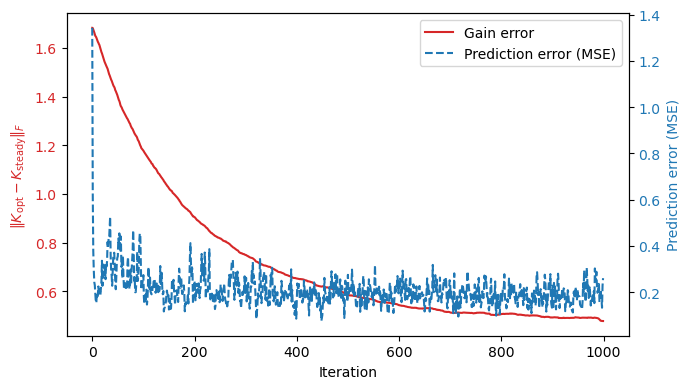

In [30]:
fig, ax1 = plt.subplots(figsize=(7, 4))

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\|K_\mathrm{opt} - K_\mathrm{steady}\|_F$', color=color)
ax1.plot(norms, label='Gain error', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Prediction error (MSE)', color=color)
ax2.plot(prediction_errors, label='Prediction error (MSE)', color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
fig.tight_layout()
#plt.title('Optimization and Prediction Errors over Iterations')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)


if live:
    plt.savefig("nonlinear_gain_errors_live.pdf")
else:
    plt.savefig("nonlinear_gain_errors.pdf")
#plt.show()

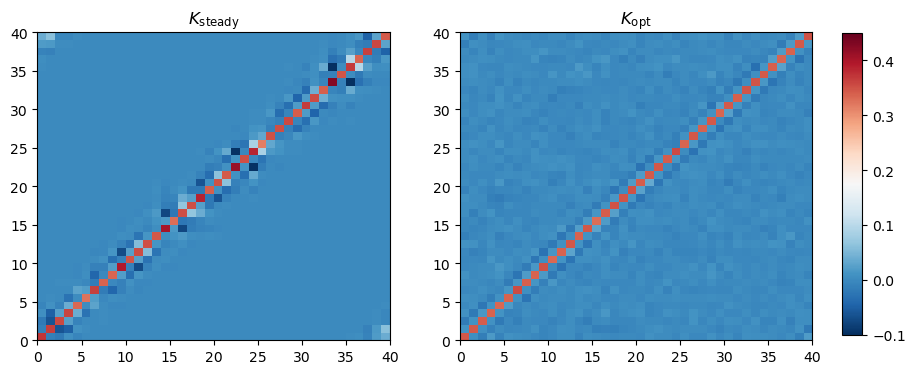

In [36]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)

ax1.pcolormesh(K_steady, vmin=-0.1, vmax=0.45, cmap='RdBu_r')
ax1.set_title('$K_\mathrm{steady}$')
p2 = ax2.pcolormesh(K_opt, vmin=-0.1, vmax=0.45, cmap='RdBu_r')
ax2.set_title('$K_\mathrm{opt}$')
cb_ax = fig.add_axes([.93,.124,.02,.754])
fig.colorbar(p2,orientation='vertical',cax=cb_ax)

if live:
    plt.savefig("nonlinear_gains_live.pdf")
else:
    plt.savefig("nonlinear_gains.pdf")

    

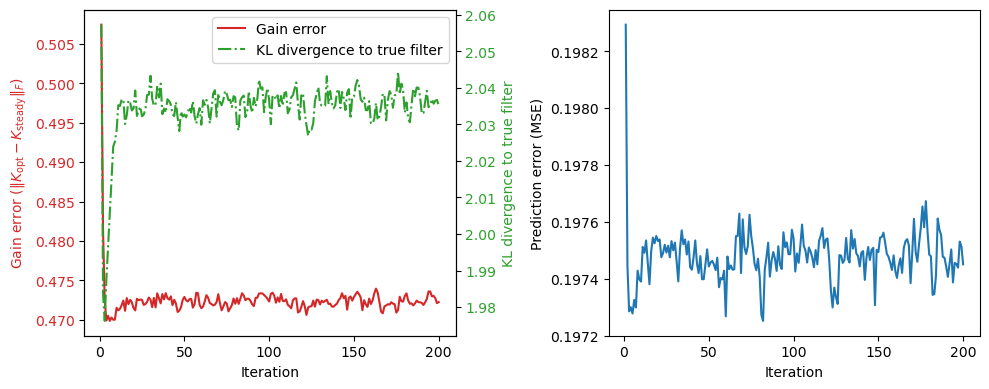

In [46]:
import matplotlib.pyplot as plt

fig, (ax1, ax3) = plt.subplots(figsize=(10, 4), ncols=2)

# Optimization Error
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Gain error ($\|K_\mathrm{opt} - K_\mathrm{steady}\|_F$)', color=color)
line1, = ax1.plot(range(1, n_iters+1), norms[:n_iters], label='Gain error', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis for Prediction Error and True Divergence
ax2 = ax1.twinx()
color_pred = 'tab:green'
ax2.set_ylabel('KL divergence to true filter', color=color_pred)
#line1, = ax2.plot(prediction_errors, label='Prediction Error (MSE)', color=color_pred, linestyle='--')
line2, = ax2.plot(range(1, n_iters+1), true_div[:n_iters], label='KL divergence to true filter', color=color_pred, linestyle='-.')
ax2.tick_params(axis='y', labelcolor=color_pred)

# Title and combined legend
#plt.title('Gain errors and KL divergence over iterations')

# Creating a combined legend for all lines
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

ax3.plot(range(1, n_iters+1), prediction_errors[:n_iters])
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Prediction error (MSE)")

plt.tight_layout()
#plt.show()
if live:
    plt.savefig("nonlinear_gain_live.pdf")
else:
    plt.savefig("nonlienar_gain.pdf")